# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчати лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решта комірок з кодом (без коментарів) потрібно просто виконати. Крім того, в завданні потрібно відповідати на питання; відповіді потрібно вписувати після виділеного слова __"Відповідь:"__.

Нагадуємо, щоб отримати  довідку будь-якого методу або функції (дізнатися, які у неї аргументи і що вона виконує) можна за допомогою комбінації Shift + Tab. Натискання Tab після імені об'єкта і точки дозволяє подивитися, які методи і змінні є у цього об'єкта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, в якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також число прокатів в цей день. Останнє ми будемо передбачати; таким чином, ми будемо вирішувати завдання регресії.

### Знаймство з даними

Завантажте датасета за допомогою функції __pandas.read_csv__ в змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
# зчитати дані та и вивести перші 5 строчок
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі наступні ознаки (як вони були вказані в джерелі даних):
* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 - немає свята, 1 - є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура по відчуттях в Цельсіях
* _hum_: вологість
* _windspeed (mph) _: швидкість вітру в милях на годину
* _windspeed (ms) _: швидкість вітру в метрах в секунду
* _cnt_: кількість орендованих велосипедів (це цільову ознаку, його ми будемо передбачати)

Отже, у нас є дійсні, бінарні і номінальні (порядкові) ознаки, і з усіма з ними можна працювати як з дійсними. З номінальниемі ознаками теж можна працювати як з дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

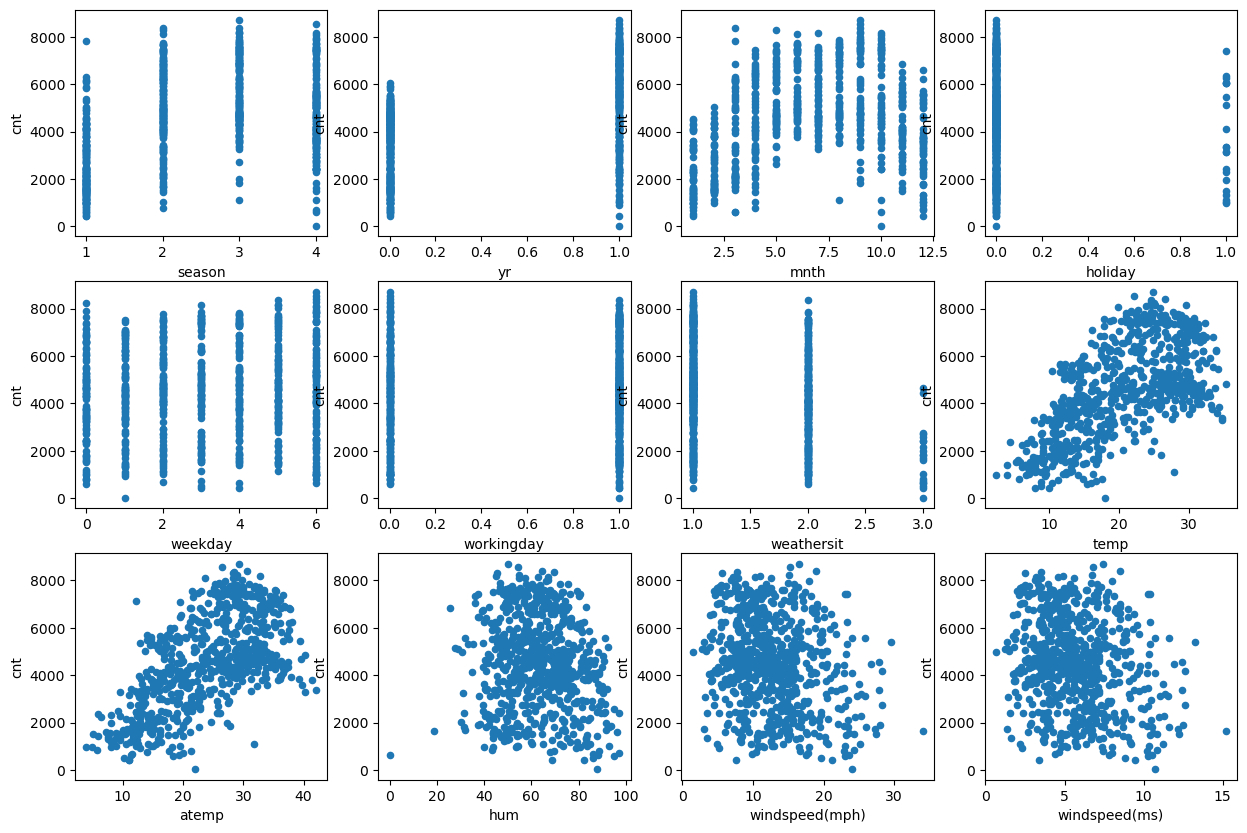

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Дайте відповідь на питання (кожене 0.5 бала):__
1. Який характер залежності числа прокатів від місяця?
    * Відповідь: нелінійна
1. Вкажіть один або дві ознаки, від яких число прокатів швидше за все залежить лінійно
    * Відповідь: temp(температура), atemp(температура по відчуттях)

Давайте більш строго оцінимо рівень лінійної залежності між ознаками і цільової змінної. Доброю мірою лінійної залежності між двома векторами є кореляція Пірсона. У pandas її можна порахувати за допомогою двох методів датафрейма: __corr__ і __corrwith__. Метод df.corr обчислює матрицю кореляцій всіх ознак з датафрейма. Методу df.corrwith потрібно подати ще один датафрейм як аргумент, і тоді він вважатиме попарні кореляції між ознаками з df і цього датафрейма.

In [4]:
# Код 1.1 (0.5 балла)
# Обчиліть кореляції всіх ознак, крім останнього, з останнім за допомогою методу corrwith: 
df11 = df[df.columns[:-1]]
df11.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [5]:
df.corrwith(df['cnt'])
# 2 спосіб
# for idx, feature in enumerate(df.columns[:-1]):
#    print(df[feature].corr(df['cnt']))

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

У вибірці є ознаки, що корелюють з цільовою, а значить, завдання можна вирішувати лінійними методами.

За графіками видно, що деякі ознаки схожі одна на одну. Тому давайте також обчислемо  кореляції між дійсними ознаками.

In [6]:
# Код 1.2 (0.5 бала)
# Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed (mph), windspeed (ms) і cnt
# за допомогою методу corr:
df12 = df[df.columns[7:]]
df12.corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і годиться, стоять одиниці. Однак в матриці є ще дві пари стовпців, які сильно корелюють : temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто перехід  одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Наостанок подивимося середні значення ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

In [7]:
# Код 1.3 (0.5 бала)
# Виведіть середні значення ознак
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, значить для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: Колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожих. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як би відбувалося навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу __scale__.

Крім того, потрібно перемішати вибірку, це потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
# Код 2.1 (1 бал)
# Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі
# (Ваги зберігаються в змінної coef_ класу регресора).
# Можна виводити пари (назва ознаки, вага), скориставшись функцією zip, вбудованої в мову python
# Назви ознак зберігаються в змінної df.columns
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.8005756556615178

In [12]:
reg.coef_

array([ 5.70867847e+02,  1.02197148e+03, -1.41303518e+02, -8.67600772e+01,
        1.37223893e+02,  5.63937505e+01, -3.30233916e+02,  3.67469835e+02,
        5.85560617e+02, -1.45606567e+02,  1.24577448e+13, -1.24577448e+13])

In [13]:
list(zip(df.columns, reg.coef_))

[('season', 570.8678469954541),
 ('yr', 1021.9714822698729),
 ('mnth', -141.30351841518018),
 ('holiday', -86.76007721429757),
 ('weekday', 137.22389285787483),
 ('workingday', 56.393750455787384),
 ('weathersit', -330.233916215271),
 ('temp', 367.4698350590794),
 ('atemp', 585.5606170155796),
 ('hum', -145.60656733256164),
 ('windspeed(mph)', 12457744791409.74),
 ('windspeed(ms)', -12457744791608.197)]

Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більше, ніж при інших ознаках.

Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$w = (X^TX)^{-1} X^T y$.

Якщо в X є Колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більше залежні ознаки, тим менше визначник цієї матриці і тим гірше апроксимація $Xw \approx y$. Така ситуацію називають _проблемою мультіколлінеарності_, ми обговорювали її на лекції.

З парою temp-atemp змінних, які корелюють трохи менше, такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами біля схожих ознаках.

__Розв'язок__ проблеми мультиколінеарності полягає в _регулярізаціі_ лінійної моделі. До оптимизаційного  функціоналу додають L1 або L2 норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge. Детальніше про це також розказано в лекції.

Навчіть регресори Ridge і Lasso з стандартними параметрами (по умолчанию) і переконайтеся, що проблема з вагами зникли.

In [14]:
from sklearn.linear_model import Lasso, Ridge

In [15]:
# Код 2.2 (0.5 бала)
# Навчіть лінійну модель з L1-регуляризатором і виведіть ваги
reg_L1 = Lasso()
reg_L1.fit(X, y)

Lasso()

In [16]:
reg_L1.coef_

array([ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02, -8.61527813e+01,
        1.37347894e+02,  5.52123706e+01, -3.32369857e+02,  3.76363236e+02,
        5.76530794e+02, -1.44129155e+02, -1.97139689e+02, -2.80390436e-08])

In [17]:
list(zip(df.columns, reg_L1.coef_))

[('season', 560.2416160308868),
 ('yr', 1019.4634940657196),
 ('mnth', -128.73062703678764),
 ('holiday', -86.152781333711),
 ('weekday', 137.34789390496317),
 ('workingday', 55.21237064135667),
 ('weathersit', -332.3698569623486),
 ('temp', 376.3632362096957),
 ('atemp', 576.5307935045539),
 ('hum', -144.12915500348606),
 ('windspeed(mph)', -197.13968940249657),
 ('windspeed(ms)', -2.8039043578214148e-08)]

In [18]:
# Код 2.3 (0.5 бала)
# Навчіть лінійну модель з L2-регуляризатором і виведіть ваги
reg_L2 = Ridge()
reg_L2.fit(X, y)

Ridge()

In [19]:
reg_L2.coef_

array([ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
        138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
        566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115])

In [20]:
list(zip(df.columns, reg_L2.coef_))

[('season', 563.0645722520183),
 ('yr', 1018.9483787875304),
 ('mnth', -131.87332028247766),
 ('holiday', -86.74609799709206),
 ('weekday', 138.0051111787191),
 ('workingday', 55.903110375064855),
 ('weathersit', -332.34978849907304),
 ('temp', 386.4578891919273),
 ('atemp', 566.3470470600479),
 ('hum', -145.07132729867214),
 ('windspeed(mph)', -99.25944108186037),
 ('windspeed(ms)', -99.25944115427262)]

### Проблема друга: неінформативні ознаки

На відміну від L2-регуляризації, L1 обнуляє ваги при деяких ознаках. Пояснення даним фактом дається в одній з лекцій.

Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$ (в лекції коефіцієнт біля регуляризатора міг бути позначений іншою буквою).

In [21]:
# Код 3.1 (1 бал)
alphas = np.arange (1, 500, 50)
coefs_lasso = np.zeros ((alphas.shape [0], X.shape [1])) # матриця ваг розміру (число регресорів) x (число ознак)
coefs_ridge = np.zeros ((alphas.shape [0], X.shape [1]))
# Для кожного значення коефіцієнта з alphas навчіть регресора Lasso
# і запишіть ваги до відповідного рядка матриці coefs_lasso (згадайте вбудовану в python функцію enumerate),
# а потім навчіть Ridge і запишіть ваги в coefs_ridge.
for idx, feature in enumerate(alphas):
    #print (idx, alphas[idx])
    reg_31_L1 = Lasso(alpha=alphas[idx])
    reg_31_L1.fit(X, y)
    coefs_lasso[idx] = reg_31_L1.coef_
#coefs_lasso

In [22]:
for idx, feature in enumerate(alphas):
    #print (idx, alphas[idx])
    reg_31_L2 = Ridge(alpha=alphas[idx])
    reg_31_L2.fit(X, y)
    coefs_ridge[idx] = reg_31_L2.coef_
#coefs_ridge 

Візуалізуємо динаміку ваг при збільшенні параметра регуляризації:

Text(0.5, 1.0, 'Ridge')

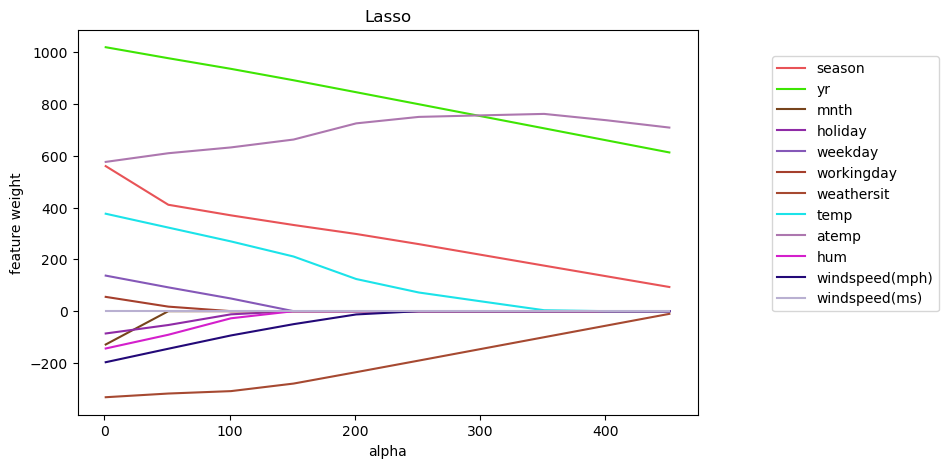

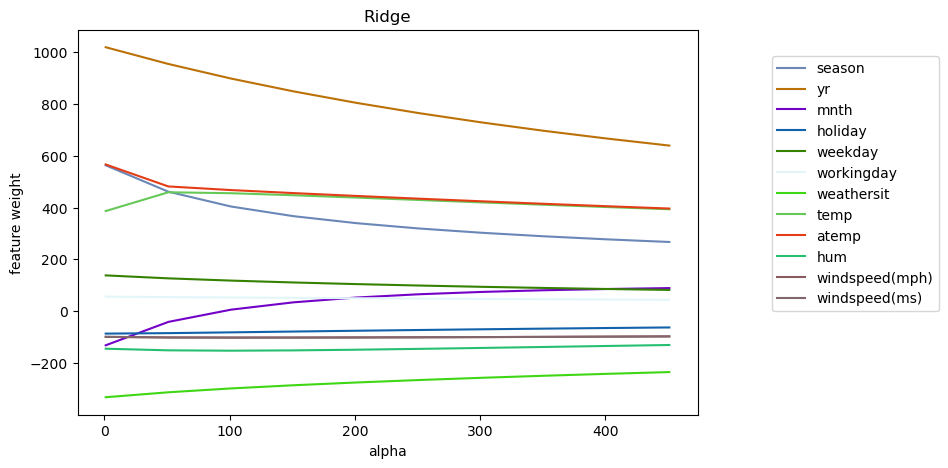

In [23]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Відповіді на такі питання можна давати, дивлячись на графіки або виводячи коефіцієнти на друк.

__Блок 2. Дайте відповідь на питання (кожене 0.25 бала)__:
1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному і тому ж alpha?
    * Відповідь: Lasso
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
    * Відповідь: якщо збільшити сильно alpha то ваги стануть дорівнювати 0.
    * L1 регуляризатор не є гладким та має цікаву властивість. Якщо застосовувати такий регуляризатор, деякі ваги виявляються   
    * такими що дорівнюють нулю. Тобто, такий регуляризатор виконує відбір ознак і дозволяє використовувати в моделі не всі 
    * ознаки, а тільки найважливіші з них.
1. Чи можна стверджувати, що Lasso виключає один з ознак windspeed при будь-якому значенні alpha> 0? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт біля  ньому <1e-3.
    * Відповідь: для Lasso - так, а для Ridge - ні.
    * Бо в Lasso степінь біля коефіцієнта windspeed(ms) => e-08 (< 1e-3).
    * А  в Ridge степінь біля коефіцієнтів > 1e-3.
1. Який з регуляризатора підійде для відбору неінформативних ознак?
    * Відповідь: Lasso

Далі будемо працювати з Lasso.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha. 

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику якості сам  функціонал методу найменших квадратів, який оптимізуються, тобто Mean Square Error.

По-друге, потрібно зрозуміти, на яких даних цю метрику обчислювати. Не можна вибирати alpha за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде будувати припущення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну і тестову (це називається holdout), то настроїмося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиттів вибірки, на кожній пробувати різні значення alpha, а потім усереднювати MSE. Зручніше за все робить такі розбиття крос-валідація, тобто розділити вибірку на K частин, або блоків, і кожен раз брати одну з них як тестову, а з решти блоків складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv = 3 by default) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків в крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінної alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що мають такий alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресорів alphas_.

In [24]:
from sklearn.linear_model import LassoCV

In [25]:
# Код 3.2 (1 бал)
# Навчіть регресор LassoCV на всіх параметрах регуляризації з alpha
# Побудуйте графік _усредненного_ по рядках MSE в залежності від alpha.
# Виведіть вибране alpha, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів
alphas = np.arange (1, 100, 5)

In [26]:
# Навчіть регресор LassoCV на всіх параметрах регуляризації з alpha
reg_32 = LassoCV(alphas=alphas,  cv = 3)
reg_32.fit(X, y)
coefs_LassoCV = reg_32.coef_
coefs_LassoCV

array([ 5.32018983e+02,  1.01506022e+03, -1.00039526e+02, -8.32939599e+01,
        1.32504465e+02,  5.15570856e+01, -3.30559857e+02,  3.70679855e+02,
        5.81396931e+02, -1.40007406e+02, -1.91771408e+02, -2.68438033e-08])

In [27]:
mse_ = reg_32.mse_path_

In [28]:
# Побудуйте графік _усредненного_ по рядках MSE в залежності від alpha.

In [29]:
mean_mse = mse_.mean(axis=1)
mean_mse

array([851097.97556673, 844888.21156583, 839042.30891536, 833559.17934129,
       828438.72799191, 823680.87676286, 819285.55495756, 815252.69915065,
       811582.25286145, 808274.1660866 , 805329.65107759, 802745.81156384,
       800525.55750255, 798642.91265887, 796928.77526934, 795177.42985684,
       793826.01832989, 792028.11513622, 790397.72811014, 825435.81203953])

Text(0.5, 1.0, 'Графік усредненного по рядках MSE в залежності від alpha')

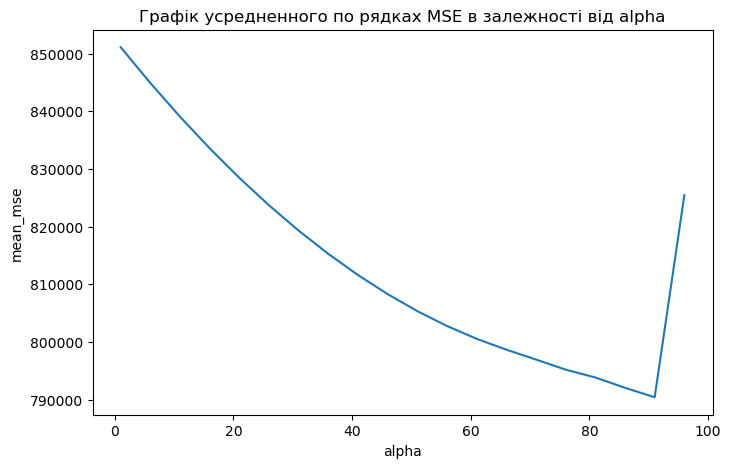

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(alphas, mean_mse)
plt.xlabel("alpha")
plt.ylabel("mean_mse")
plt.title("Графік усредненного по рядках MSE в залежності від alpha")

In [31]:
# Виведіть вибране alpha, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів

In [32]:
reg_32.alpha_

6

In [33]:
list(zip(df.columns, coefs_LassoCV))

[('season', 532.0189828413538),
 ('yr', 1015.0602226430597),
 ('mnth', -100.03952614356652),
 ('holiday', -83.29395987529911),
 ('weekday', 132.50446549095813),
 ('workingday', 51.55708561407377),
 ('weathersit', -330.55985673998146),
 ('temp', 370.6798550300316),
 ('atemp', 581.3969310655002),
 ('hum', -140.0074055006887),
 ('windspeed(mph)', -191.7714084713614),
 ('windspeed(ms)', -2.6843803308483105e-08)]

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку тільки один раз на навчальну і тестову, тобто розглянемо траєкторії MSE, відповідні окремим блокам вибірки.

In [34]:
# Код 3.3 (1 бал)
# Виведіть значення alpha, відповідні мінімумам MSE на кожному розбитті (тобто по стовпцях).
# На трьох окремих графіках візуалізуйте стовпці .mse_path_
min_mse = mse_.min(axis=0)
min_mse

array([843336.18149882, 772598.49562777, 745668.6059608 ])

На кожному розбитті оптимальне значення alpha своє, і йому відповідає велика MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі alpha на крос-валідації ми вибираємо щось "середнє", що буде давати прийнятне значення метрики на різних розбиттях вибірки.

Нарешті, як прийнято в аналізі даних, давайте проінтерпретіруемо результат.

__Блок 3. Дайте відповідь на питання (кожене 0.5 бала):__
1. В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно  зростаюча лінійна залежність cnt від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?
    * Відповідь: 
    * 'yr',     1015.0602
    * 'atemp',  581.39693
    * 'season', 532.01898
    * 'temp',   370.67985
    *  Зростаюча лінійна залежність за графіками видна була тільки на temp(температура), atemp(температура по відчуттях), тут 
    * ми бачимо ще ознаки. Так, видно. Чим більші значення то більший вплив тієї чи ін. ознаки. Чим більші значення параметру, 
    * то більш ймовірно що люди візьмуть велосипед. 
1. Виберіть 3 ознаки з найбільшими за модулями від'ємними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно  спадну лінійну залежність? Чи логічно стверджувати, що чим більше величина цих ознак, тим менше людей захочуть взяти велосипеди?
    * Відповідь:
    * 'weathersit',     -330.559
    * 'windspeed(mph)', -191.771
    * 'hum',            -140.0074
    * Видно невелику спадну залежність. Так, логічно. 
1. Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви думаєте, чому модель виключила їх з моделі (знову подивіться на графіки)? Чи вірно, що вони ніяк не впливають на попит на велосипеди?
    * Відповідь: 'windspeed(ms)', -2.6843803308483105e-08. Так.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, по можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто відзначити, що за допомогою крос-валідації зручно підбирати лише невелике число параметрів (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться кілька разів навчати модель, а це часозатратний процес, особливо якщо потрібно навчатися на великих обсягах даних.